## Asset Pricing HW2

#### Brian Wickman
#### October 2025

In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt

### 1. Consider the approximiation error for the linear approximation of investor marginal utility

Consider an investor with constant relative risk aversion with relative risk aversion $\gamma = 2$ and initial wealth $W_0 =1$. Plot the CRRA utility function for $W\in [0.3, 2]$.
    \begin{align*}
        U(W) &= \frac{W^{1-\gamma}}{1-\gamma} \text{ if } \gamma \neq 1, \quad \text{else} \quad U(W) = \log W\\
        U^{\prime}(W) &= W^{-\gamma}
    \end{align*}
   
On the same plot, draw the linear approx for marginal utility, assuming $\mathbb{E}[R_w] \approx 1, R_w = \frac{W}{W_0} = W$:
    $$\frac{U^{\prime}(W)}{U^{\prime}(\mathbb{E}[W])} \approx 1 - \gamma(R_w - \mathbb{E}[R_w]) \approx 1 - \gamma(W - 1)$$
    
As expected, the linear approximation for marginal utility only works for small changes in wealth, which makes sense since it is derived using the Taylor expansion. The linear approximation ignores higher order terms and systematically underestimating the marginal utility, substantially so for large decreases in wealth.

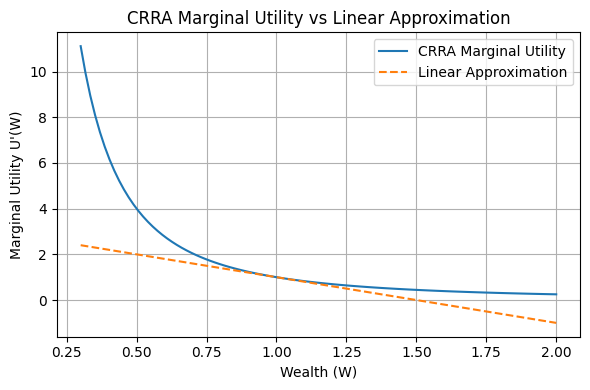

In [5]:
# Parameters
W = np.linspace(0.3, 2, 100)
gamma = 2  # example value for risk aversion
W_mean = 1.0

# Marginal Utility for CRRA
def U_prime(W, gamma):
   return W**(-1 * gamma)

# Linear approximation of marginal utility 
def U_prime_linear(W, gamma):
   return 1 - gamma*(W-1)

# Plot
plt.figure(figsize=(6,4))
plt.plot(W, U_prime(W, gamma), label='CRRA Marginal Utility')
plt.plot(W, U_prime_linear(W, gamma), '--', label='Linear Approximation')
plt.xlabel('Wealth (W)')
plt.ylabel("Marginal Utility U'(W)")
plt.title('CRRA Marginal Utility vs Linear Approximation')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


### 2a. Optimal portfolio share

Consider the CRRA investor's portfolio problem. Define risk-free rate $R_f = 1.2$ and risky asset returns $R \sim N(\mu, \sigma^2)$ with $\mu = 0.1, \sigma^2 = 0.6$. Calculate the optimal portfolio share using formula (1.11) based on the linear approximation of marginal utility.
   $$\omega = \frac{\mathbb{E}[R - R_f]}{\gamma \text{var}(R)}$$

Note that the risky asset returns are log-normally distributed, implying the following moments for the returns:
   \begin{align*}
      \mathbb{E}[R] &= \exp\left(\mu + \frac{\sigma^2}{2} \right)\\
       &= \exp(0.1 + 0.36/2) \approx 1.323\\
      \text{Var}[R] &= [\exp(\sigma^2) - 1]\exp(2\mu + \sigma^2) \\
      &= (\exp(0.36) - 1)(\exp(0.2 + 0.36)) \approx 0.759
   \end{align*}

In [16]:
# Calculate moments
mu_R = np.exp(0.28)
var_R = (np.exp(0.36) - 1) * (np.exp(0.56))
print(f'Risky returns distributed normally with mean {mu_R:.4f} and variance {var_R:.4f}')

# Calculate optimal portfolio share
R_f, gamma = 1.02, 2
port_share_analytic = (mu_R - R_f)/ (gamma * var_R)
print(f'Optimal portfolio share to risky asset: {port_share_analytic:.2%}')

Risky returns distributed normally with mean 1.3231 and variance 0.7586
Optimal portfolio share to risky asset: 19.98%


### 2b. Numerical solution for optimal portfolio share

Evaluate investor's expected utility via Monte Carlo integration over a grid of values from -1 to 2:
   $$\mathbb{E}[U(W)] \approx \frac{1}{N}\sum_{i=1}^N U(W_i)$$
where $W_i$ depends on the probability distribution of the risky asset return (1.6):
   $$W_i = \omega R_i + (1 - \omega)R_f, \quad R_i \sim N(1.323, 0.7586)$$
 Note that investors have limited liability, so wealth has a lower bound at zero. My first observation is that $\gamma = 2$ creates a strictly negative utility function.
    $$U(W) = \frac{-1}{W}$$

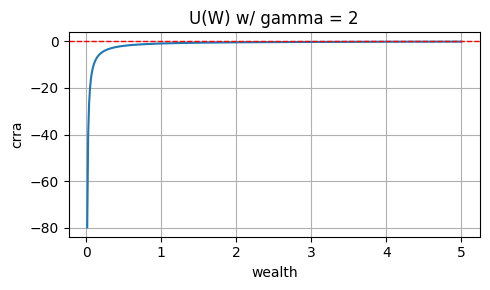

In [87]:
# Plot the CRRA utility function with gamma = 2
x = np.linspace(0, 5, 400); x = x[x != 0]  # Remove zero to avoid division by zero
y = -1 / x

plt.figure(figsize=(5,3))
plt.plot(x, y)
plt.axhline(0, color='r', linestyle='dashed', linewidth=1)
plt.xlabel('wealth'); plt.ylabel('crra'); plt.title('U(W) w/ gamma = 2')
plt.grid(True); plt.tight_layout(); plt.show()

Regardless, I proceed with the analysis

In [88]:
# CRRA relative utility function
# how to handle low levels of wealth, especially 0
def crra_utility(w, gamma):
    if gamma == 1:
        return np.log(w)  # avoid log(0)
    else:
        util_vec = w ** (1 - gamma) / (1 - gamma)
        return  np.where(util_vec < -50, 0, util_vec)
    
# Estimate expected utility via Monte Carlo integration
gamma = 2 # crra relative risk aversion
def MonteCarlo_int(omega, N, ret_distributions = False):
   # Draw N risky asset returns
   R_risky = np.random.normal(loc = mu_R, scale = np.sqrt(var_R), size = N) # standard dev, not variance
   wealth = omega * R_risky + (1-omega) * R_f
   wealth = np.clip(wealth, 1e-8, None) # avoid 0 or negative wealth
   
   # check distributions in MC simulation
   if ret_distributions:
       return wealth, crra_utility(wealth, gamma), np.mean(crra_utility(wealth, gamma))
   return np.mean(crra_utility(wealth, gamma)) # average utility of wealth

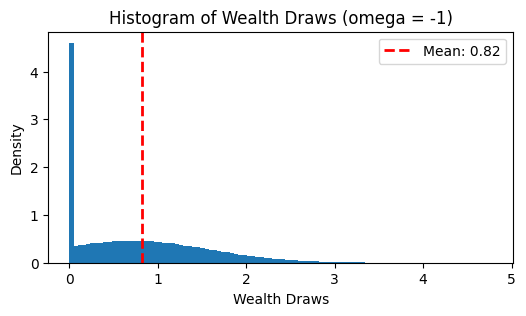

In [105]:
# possible wealth draws under omega = 1 (returns risky asset performance)
tmp_omega = -1
wealth_dist, util_dist, mc_results = MonteCarlo_int(omega= tmp_omega, N=int(1e6), ret_distributions=True)

# plot distribution of wealth
plt.figure(figsize=(6,3))
plt.hist(wealth_dist, bins=100, density=True)
mean_wealth = np.mean(wealth_dist) # add mean to histogram
plt.axvline(mean_wealth, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_wealth:.2f}')
plt.xlabel('Wealth Draws'); plt.ylabel('Density')
plt.title(f'Histogram of Wealth Draws (omega = {tmp_omega})')
plt.legend(); plt.show()

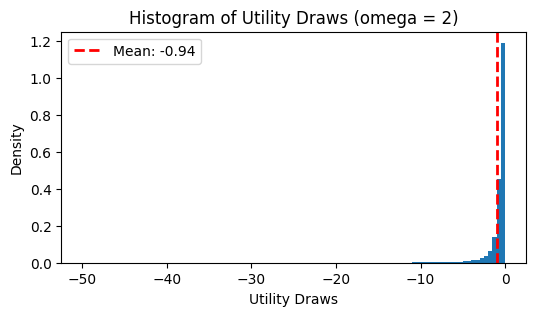

In [104]:
# plot distribution of utility(wealth)
plt.figure(figsize=(6,3))
plt.hist(util_dist, bins=100, density=True)
mean_util = np.mean(util_dist) # add mean to histogram
plt.axvline(mean_util, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_util:.2f}')
plt.xlabel('Utility Draws'); plt.ylabel('Density')
plt.title(f'Histogram of Utility Draws (omega = {tmp_omega})')
plt.legend(); plt.show()

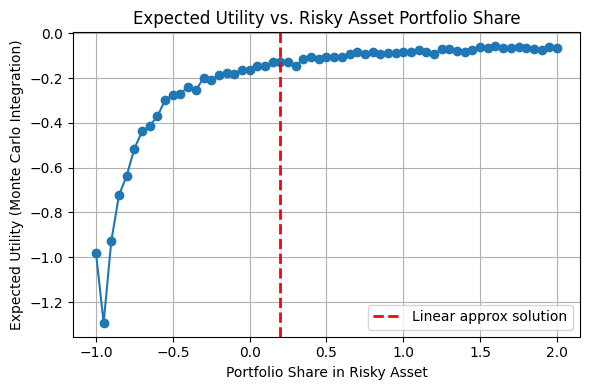

In [101]:
# Estimate for range of portfolio shares
port_share_range = np.arange(-1, 2.05, 0.05)
expected_util_MC = []
for tmp_port_share in range(len(port_share_range)):
    expected_util_MC.append(MonteCarlo_int(omega = tmp_port_share, N = 10**4))
  
# Expected utility ~ f(portfolio share)
plt.figure(figsize=(6,4))
plt.plot(port_share_range, expected_util_MC, marker='o')
plt.axvline(port_share_analytic, color='r', linestyle='dashed', linewidth=2, label="Linear approx solution")
plt.xlabel('Portfolio Share in Risky Asset')
plt.ylabel('Expected Utility (Monte Carlo Integration)')
plt.title('Expected Utility vs. Risky Asset Portfolio Share')
plt.grid(True);plt.tight_layout();plt.legend();plt.show()

Loves levered positions if E(R) > E(R_f) and investors have limited liability (we chop off negative stnadard deviation outcomes). Really does not like shorting the risky asset because often leads to wipe outs and the gets rid of the positive standard deviation outcomes as risk-free rate never has positive shocks. Optimal share of risky asset much different than 2.1 because wealth shocks are large, i.e. wealth goes from 1 to anywhere between 0 and 5, so linear approx fails to capture the nonlinear effects (see graph 1). similar to duration being bad estimate of bond price movement if price shock is large.